In [ ]:
#| include: false
# TensorFlow utils
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
#| include: false
# Other imports
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

Data augmentation is a favorite recipe among deep learning practitioners especially for the ones working in the field of computer vision. Data augmentation is a technique used for introducing variety in training data thereby helping to mitigate overfitting. 

When using Keras for training image classification models, using the `ImageDataGenerator` class for handling data augmentation is pretty much a standard choice. However, with TensorFlow, we get a number of different ways we can apply data augmentation to image datasets. In this tutorial, we are going to discuss three such ways. Knowing about these different ways of plugging in data augmentation in your image classification training pipelines will help you decide the best way for a given scenario. 

Here’s a brief overview of the different ways we are going to cover:

- Using the standard ImageDataGenerator class
- Using TensorFlow image ops with a TensorFlow dataset
- Using Keras’s (experimental) image processing layers
- Mix-matching different image ops & image processing layers 
 
Let’s get started! 


# Experimental setup
We are going to use the flowers dataset to demonstrate the experiments. Downloading the dataset is just as easy as executing the following line of code: 

`flowers` contains the path (which in my case is - `/root/.keras/datasets/flower_photos`) where the dataset got downloaded. The structure of the dataset looks like so - 

```
├── daisy [633 entries]
├── dandelion [898]
├── roses [641]
├── sunflowers [699 entries]
├── tulips [799 entries]
└── LICENSE.txt
```

In [ ]:
# Get the flowers dataset
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [ ]:
#| include: false
# Classes
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Using the standard ImageDataGenerator class
For most of the scenarios, the ImageDataGenerator should be good enough. Its flexible API design is really to follow and it makes it easier to work with custom image datasets by providing meaningful high-level abstractions. 

We instantiate the ImageDataGenerator class like so - 

In [ ]:
#| include: false
# Image plotting utils
def show_batch(image_batch, label_batch, image_data_gen=True):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])
        
        if image_data_gen:
            plt.title(CLASSES[label_batch[n].argmax()])
        else:
            plt.title(label_batch[n].decode("utf-8"))
        
        plt.axis('off')

In [ ]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
	rescale=1./255,
	rotation_range=30,
	horizontal_flip=True)

We specify two augmentation operations and a pixel rescaling operation in there. `ImageDataGenerator` comes with a handy `flow_from_directory` method that allows us to read images from a directory and apply the specified operations on the fly during the time of training. Here’s how to instruct the `img_gen` object to read images from a directory - 


In [ ]:
IMG_SHAPE = 224
BATCH_SIZE = 32

img_flow = img_gen.flow_from_directory(flowers, 
    shuffle=True, 
    batch_size=BATCH_SIZE,
    target_size=(IMG_SHAPE, IMG_SHAPE))

Found 3670 images belonging to 5 classes.


We then verify the images and the labels and they are indeed parsed right - 

(32, 224, 224, 3) (32, 5)


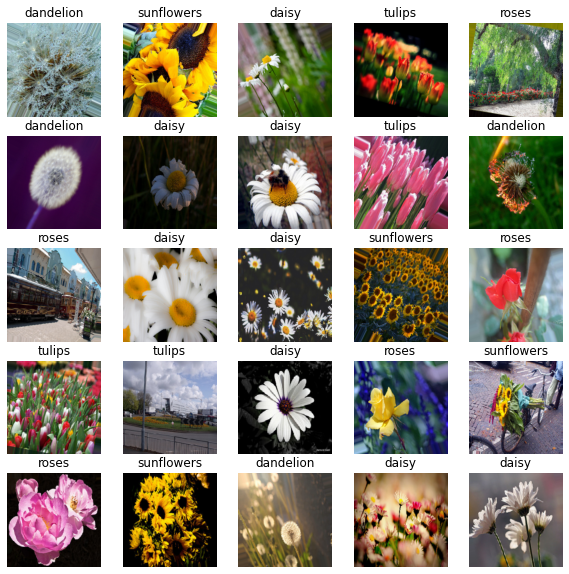

In [ ]:
images, labels = next(img_flow)
print(images.shape, labels.shape)
show_batch(images, labels)

Training with an ImageDataGenerator instance is extremely straight-forward - 

```python
model = get_training_model()
model.fit(img_flow, ...)
```

For a fully worked out example, refer to [this tutorial](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/). 

As can be seen in [this blog post](https://www.tensorflow.org/tutorials/load_data/images#performance), `ImageDataGenerator`’s overall data loading performance can have a significant effect on how fast your model trains. To tackle situations, where you need to maximize the hardware utilization without burning unnecessary bucks, [TensorFlow’s data module](https://www.tensorflow.org/guide/data) can be really helpful (comes at some costs).  


# TensorFlow image ops with tf.data APIs

The blog post I mentioned in the previous section shows the kind of performance boost achievable with `tf.data` APIs. But it’s important to note that boost comes at the cost of writing boilerplate code which makes the overall process more involved. For example, here’s how you would load and preprocess your images and labels - 


In [ ]:
def parse_images(image_path):
    # Load and preprocess the image
    img = tf.io.read_file(image_path) # read the raw image
    img = tf.image.decode_jpeg(img, channels=3) # decode the image back to proper format
    img = tf.image.convert_image_dtype(img, tf.float32) # scale the pixel values to [0, 1] 
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE]) # resize the image

    # Parse the labels
    label = tf.strings.split(image_path, os.path.sep)[5]

    return (img, label)

You would then write a separate augmentation policy with the [TensorFlow Image ops](https://www.tensorflow.org/api_docs/python/tf/image) - 


In [ ]:
def augment(image, label):
    img = tf.image.rot90(image)
    img = tf.image.flip_left_right(img)
    return (img, label)

To chain the above two together you would first create an initial dataset consisting of only the image paths - 

In [ ]:
image_paths = list(paths.list_images(flowers))
list_ds = tf.data.Dataset.from_tensor_slices((image_paths))

Now, you would read, preprocess, shuffle, augment, and batch your dataset - 

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

train_ds = (
    list_ds
    .map(parse_images, num_parallel_calls=AUTO)
    .shuffle(1024)
    .map(augment, num_parallel_calls=AUTO) # augmentation call
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

`num_parallel_calls` allows you to parallelize the mapping function and `tf.data.experimental.AUTOTUNE` lets TensorFlow decide the level of parallelism to use dynamically (how cool is that?). prefetch allows loading in the next batch of data well before your model finishes the current epoch of training. It is evident that this process is more involved than the previous one. 

Verifying if we constructed the data input pipeline correctly is a vital step before you feed your data to the model - 


(32, 224, 224, 3) (32,)


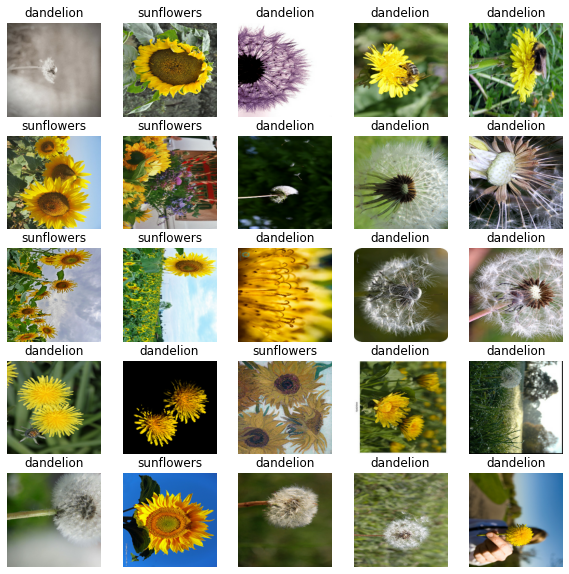

In [ ]:
image_batch, label_batch = next(iter(train_ds))
print(image_batch.shape, label_batch.shape)
show_batch(image_batch.numpy(), label_batch.numpy(), image_data_gen=False)

The “b”s appear before the class labels because TensorFlow parses the strings as byte-strings. Using train_ds with your model is also just about executing - 

```python
model = get_training_model()
model.fit(train_ds, ...)
```

[Here](https://www.tensorflow.org/tutorials/images/data_augmentation) you can find a fully worked out example. [Here](https://www.tensorflow.org/guide/data_performance) you can know more about the different performance considerations when using tf.data. There are more image ops available with **TensorFlow Addons** which can found [here](https://www.tensorflow.org/addons/tutorials/image_ops). 

Recently, Keras introduced [`image_dataset_from_directory`](https://keras.io/api/preprocessing/image/#image_dataset_from_directory) function (only available in `tf-nightly` at the time of writing this) which takes care of many of the boilerplate code we saw above and still yields pretty good performance. Here’s [a tutorial](https://colab.research.google.com/drive/1umJnCp8tZ7UDTYSQsuWdKRhqbHts38AC) that shows how to use it. 

Keras has also introduced [a number of image processing layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) which can be very useful to build flexible augmentation pipelines using the Sequential API. In the next section, let’s see how. 


# Using Keras’s (experimental) image processing layers

Just like you would construct an entire model using the `Sequential` API, you can now construct very flexible data augmentation pipelines using the newly introduced (although experimental at the time of writing this) image processing layers. If we were to convert the data augmentation operations we have been following in the tutorial so far, building a data augmentation pipeline using this approach would be like so - 

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)
])

Before passing your data through this stack of layers **makes sure you haven’t applied any augmentation already**. So, it’s safe to create a separate TensorFlow dataset without mapping the augmentation function like we previously did - 

In [ ]:
# Create TensorFlow dataset without any augmentation
train_ds = (
    list_ds
    .map(parse_images, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Now, we can see how to examine some of the augmented images that would come out of this mini pipeline - 

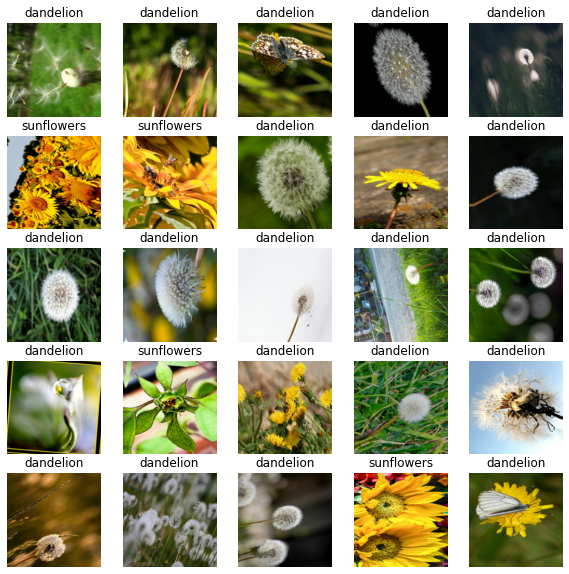

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    augmented_image = data_augmentation(tf.expand_dims(image_batch[n], 0))
    plt.imshow(augmented_image[0].numpy())
    plt.title(label_batch[n].numpy().decode("utf-8"))
    plt.axis('off')

We can also make use of Python `lambda`s to map `data_augmentation` directly to our `tf.data` pipeline like so:

```python
train_ds = (
    list_ds
    .map(parse_images, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y),
        num_parallel_calls=AUTO)
    .prefetch(AUTO)
)
```

Note that these layers can be also added as a part of your model allowing them to run on GPUs. Based on your compute budget you should decide if you would want to run these layers on the GPU or you would rather have them executed separately on the CPU.

A functional model definition in Keras using this approach may look like so - 

```python
# You define an input layer with pre-defined shapes
inputs = keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

x = data_augmentation(inputs)  # Apply random data augmentation
x = feature_extractor_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  
outputs = Dense(1)(x)

model = Model(inputs, outputs)
```

Now, `model` should be good to go with - `model.fit(train_ds, ...)`. A fully worked out example is available [here](https://colab.research.google.com/drive/17vHSAj7no7RMdJ18MJomTf8twqw1suYC#scrollTo=nhSR8l3OX_sM). Note that, performance might get slightly affected when going with this approach since the GPUs will be utilized to run the preprocessing layers as well. 

Let’s now think about situations where we may need to use a combination of the image ops of TensorFlow and the layers we just saw. What if we need to plug in custom augmentation operations in the augmentation pipeline? Added on top of it, what if we need to fix the probability at which the augmentation operations would get applied? Data augmentation pipelines are quite central behind the success of recent works like [SimCLR](https://arxiv.org/abs/2002.05709), [Augmix](https://arxiv.org/abs/1912.02781), etc. 

:::{.callout-note}

These layers have pre-defined inference-time behaviour. So even if you have included them inside your model itself, it's totally fine. But if you want them during inference, you would need to set its inference-time behaviour.

:::

# Towards more complex augmentation pipelines

In this final approach, we will see how to mix and match between the different stock image ops, and stock image processing layers. Let’s first define a class utilizing the stock image ops with a utility function to apply them at random with a pre-defined probability. 


In [ ]:
#| include: false
# Create TensorFlow dataset without any augmentation
train_ds = (
    list_ds
    .map(parse_images, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [ ]:
class CustomAugment(object):
    def __call__(self, image):        
        # Random flips and grayscale with some stochasticity
        img = self._random_apply(tf.image.flip_left_right, image, p=0.6)
        img = self._random_apply(self._color_drop, img, p=0.9)
        return img

    def _color_drop(self, x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

`_random_apply` is taken from the [official SimCLR repository](https://github.com/google-research/simclr). Now, in order to tie it together with the stock image processing layers, we can still use the `Sequential` API with a `Lambda` layer - 


In [ ]:
# Build the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Lambda(CustomAugment()),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
])

When we verify if it’s indeed correct, we get desired outputs - 

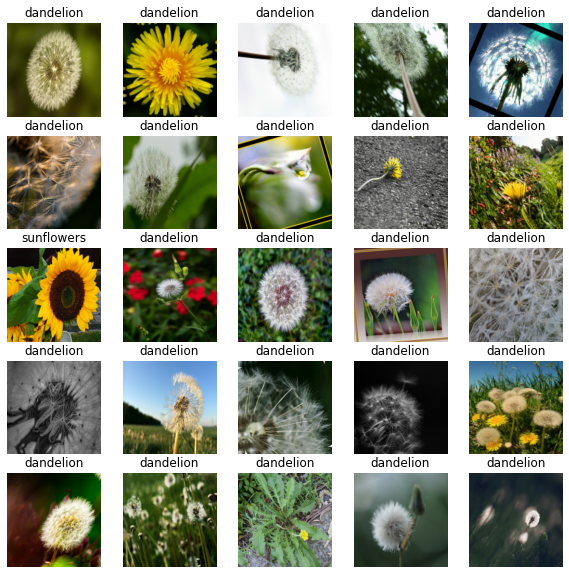

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    augmented_image = data_augmentation(tf.expand_dims(image_batch[n], 0))
    plt.imshow(augmented_image[0].numpy())
    plt.title(label_batch[n].numpy().decode("utf-8"))
    plt.axis('off')

Training models when using this approach remains the same as the previous one. Keep in mind that performance can get affected when using this approach. 

# References

- [Fine-tuning with Keras and Deep Learning](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)
- [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)
- [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)
- [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
